In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
mnist =tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [18]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train[:1000] == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test[:1000] == i)][0:test_num]


In [19]:
cm = 1.0e-2
mm = 1.0e-3
um = 1.0e-6
nm = 1.0e-9

d = 1.0 * um # 開口直径
l = 633 * nm # 波長
k = 2 * np.pi / l # 波数
z = 0.5 * mm # 伝搬距離

D = 100 * um # 計算領域
N = 500

/Users/takumi/opt/anaconda3/envs/MOD2NN/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


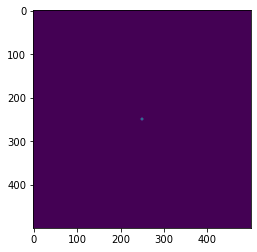

In [3]:
x = np.linspace(-D/2, D/2, N)
y = np.linspace(-D/2, D/2, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
pattern = np.where(R < d/2, 1, 0)

U = np.fft.fft2(pattern)
kx = np.fft.fftfreq(N, d=D/N) * 2 * np.pi
ky = np.fft.fftfreq(N, d=D/N) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)
kz = np.sqrt(k**2 - KX**2 - KY**2)
kz[np.isnan(kz)] = 0
plt.imshow(kz)

U_ang = np.fft.ifft2(U * np.exp(1.0j * kz * z))

I_ang = np.abs(U_ang)**2
I_ang = I_ang / np.max(I_ang)

plt.imshow(I_ang)

In [69]:
x_train = np.expand_dims(test_data["7"], axis=-1)
x_train = tf.image.resize(x_train[0:20,:,:,:], [100,100])
x_train = x_train[:,:,:,0]

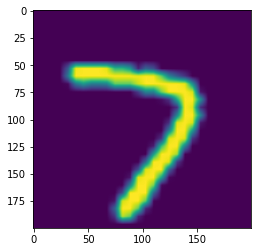

In [64]:
plt.imshow(x_train[1,:,:])

/Users/takumi/opt/anaconda3/envs/MOD2NN/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


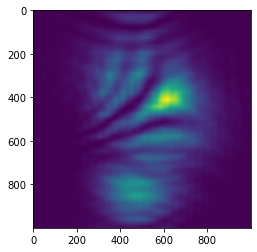

In [162]:
scale = 10

pixel_size = 1.0 * um / scale
shape = np.array([100, 100]) * scale
z = 0.5 * mm

image = np.expand_dims(x_train[0,:,:], axis=-1)
A0 = tf.image.resize(image, shape)
A0 = A0[:,:,0]

U = np.fft.fft2(A0)
kx = np.fft.fftfreq(shape[0], d=pixel_size) * 2 * np.pi
ky = np.fft.fftfreq(shape[1], d=pixel_size) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)
kz = np.sqrt(k**2 - KX**2 - KY**2)
kz[np.isnan(kz)] = 0

U_ang = np.fft.ifft2(U * np.exp(1.0j * kz * z))

I_ang = np.abs(U_ang)**2
I_ang = I_ang / np.max(I_ang)

plt.imshow(I_ang)

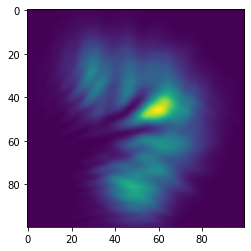

In [44]:
# expand
pixel_size = 1.0 * um
shape = (100, 100)
z = 0.5 * mm

image = tf.constant(x_train[1,:,:])
padding_image = tf.pad(image,[[int(shape[1]/2), int(shape[1]/2)], [int(shape[0]/2), int(shape[0]/2)]])

padding_shape = padding_image.shape

U = np.fft.fft2(padding_image)
kx = np.fft.fftfreq(padding_shape[0], d=pixel_size) * 2 * np.pi
ky = np.fft.fftfreq(padding_shape[1], d=pixel_size) * 2 * np.pi
KX, KY = np.meshgrid(kx, ky)
kz = np.sqrt(k**2 - KX**2 - KY**2)
kz[np.isnan(kz)] = 0

U_ang = np.fft.ifft2(U * np.exp(1.0j * kz * z))

I_ang = np.abs(U_ang)**2
I_ang = I_ang / np.max(I_ang)

I_ang = tf.slice(I_ang, [int(shape[1]/2), int(shape[1]/2)], shape)

plt.imshow(I_ang)

In [7]:
def angular_spectrum(image, z, l, d):
  k = 2 * np.pi / l
  U = np.fft.fft2(image)
  shape = image.shape
  kx = np.fft.fftfreq(shape[0], d=d) * 2 * np.pi
  ky = np.fft.fftfreq(shape[1], d=d) * 2 * np.pi
  KX, KY = np.meshgrid(kx, ky)
  kz = np.sqrt(k**2 - KX**2 - KY**2)
  kz[np.isnan(kz)] = 0

  U_ang = np.fft.ifft2(U * np.exp(1.0j * kz * z))

  I_ang = np.abs(U_ang)**2
  return I_ang / np.max(I_ang)

In [59]:
def expand_angular_spectrum(image, z, l, d, scale=4):
  src_shape = image.shape
  padding_width = int(image.shape[1] / 2 * (scale - 1))
  padding_height = int(image.shape[0] / 2 * (scale - 1))
  padding = np.array([[padding_width, padding_width],[padding_height, padding_height]])
  expand_image = np.pad(image, padding)
  k = 2 * np.pi / l
  U = np.fft.fft2(expand_image)
  shape = expand_image.shape
  kx = np.fft.fftfreq(shape[0], d=d) * 2 * np.pi
  ky = np.fft.fftfreq(shape[1], d=d) * 2 * np.pi
  KX, KY = np.meshgrid(kx, ky)
  kz = np.sqrt(k**2 - KX**2 - KY**2)
  kz[np.isnan(kz)] = 0

  U_ang = np.fft.ifft2(U * np.exp(1.0j * kz * z))
  U_ang = U_ang[padding_height:padding_height+src_shape[0], padding_width:padding_width+src_shape[1]]
  I_ang = np.abs(U_ang)**2
  I_ang = I_ang / np.max(I_ang)
  return I_ang

In [65]:
x_train = np.where(x_train >=255/2,1,0)

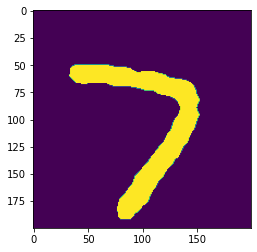

In [66]:
plt.imshow(x_train[1,:,:])

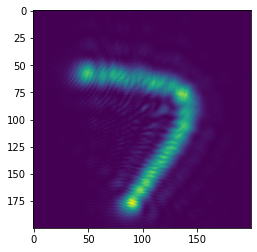

In [68]:
ang_image = expand_angular_spectrum(x_train[1,:,:], 0.5e-3, 633e-9, 1.0e-6, 4)
plt.imshow(ang_image)